In [47]:
import os
from nipype.interfaces import fsl
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
from config import root

fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

print(root)

/data/ext/PhD/Studies/PrimingDecay


In [52]:
# pathnames
base_dir = os.path.join(root, "data")
working_dir = os.path.join(base_dir, 'working_dir')

# MNI standard file
mni_standard_path = os.path.join(base_dir, "in_analysis", "nii", "standard", "MNI152_T1_2mm_brain.nii.gz")
mni_standard_mask_path = os.path.join(base_dir, "in_analysis", "nii", "standard", "MNI152_T1_2mm_brain_mask.nii.gz")

In [65]:
num_contrasts = 11
con_list = list(range(num_contrasts))
glm_prefix = 'pop_decay_submean_'

# iterate over contrasts
infosource = pe.Node(util.IdentityInterface(fields=['con_num']),
                     name='infosource')

# Define iterable attributes
infosource.iterables = [('con_num', con_list)]

# File templates for different contrasts
templates = {
    "copes" : os.path.join(
        "output", 
        glm_prefix+"L2_fixedfx_warped", "copes",
        "sub_*", "_applywarp_copes{con_num}",
        "cope1_warp.nii.gz"),
    "varcopes" : os.path.join(
        "output",
        glm_prefix+"L2_fixedfx_warped", "varcopes",
        'sub_*', '_applywarp_varcopes{con_num}',
        'varcope1_warp.nii.gz'),
}

files = pe.Node(
    SelectFiles(
        templates,
        base_directory=base_dir,
        sort_filelist=True),
    name='files')

datasink = pe.Node(
    DataSink(
        base_directory=base_dir,
        container="output"),
    name='datasink')

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [('_con_num_', '')]

In [70]:
# Concatenate copes before feeding to Flameo
merge_copes = pe.MapNode(
    interface=fsl.Merge(
        dimension='t'),
    iterfield=['in_files'],
    name="merge_copes")

merge_varcopes = pe.MapNode(
    interface=fsl.Merge(
        dimension='t'),
    iterfield=['in_files'],
    name="merge_varcopes")

# Create a level2 model
l2model_mixed = pe.Node(
    interface=fsl.L2Model(
        num_copes=6),
    name='l2model_fixed')

# A mixed effects FLAMEO node, with copes and varcopes as inputs.
mixed_flameo = pe.MapNode(
    interface=fsl.FLAMEO(
        mask_file=mni_standard_mask_path,
        run_mode = 'flame12'),
    iterfield=['cope_file', 'var_cope_file'],
    name="fixedflameo",
    overwrite=True)

In [71]:
mixed_fx = pe.Workflow(name=glm_prefix+"mixed_fx", base_dir=working_dir)

mixed_fx.connect(infosource, 'con_num', files, 'con_num')
mixed_fx.connect(files, 'copes', merge_copes, 'in_files')
mixed_fx.connect(files, 'varcopes', merge_varcopes, 'in_files')
mixed_fx.connect(merge_copes, 'merged_file', mixed_flameo, 'cope_file')
mixed_fx.connect(merge_varcopes, 'merged_file', mixed_flameo, 'var_cope_file')
mixed_fx.connect(l2model_mixed, 'design_mat', mixed_flameo, 'design_file')
mixed_fx.connect(l2model_mixed, 'design_con', mixed_flameo, 't_con_file')
mixed_fx.connect(l2model_mixed, 'design_grp', mixed_flameo, 'cov_split_file')

# Datasink
mixed_fx.connect(mixed_flameo, 'copes', datasink, glm_prefix+"mixed_fx.@copes")
mixed_fx.connect(mixed_flameo, 'var_copes', datasink, glm_prefix+"mixed_fx.@varcopes")
mixed_fx.connect(mixed_flameo, 'zstats', datasink, glm_prefix+"mixed_fx.@zstats")

180604-23:56:27,331 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


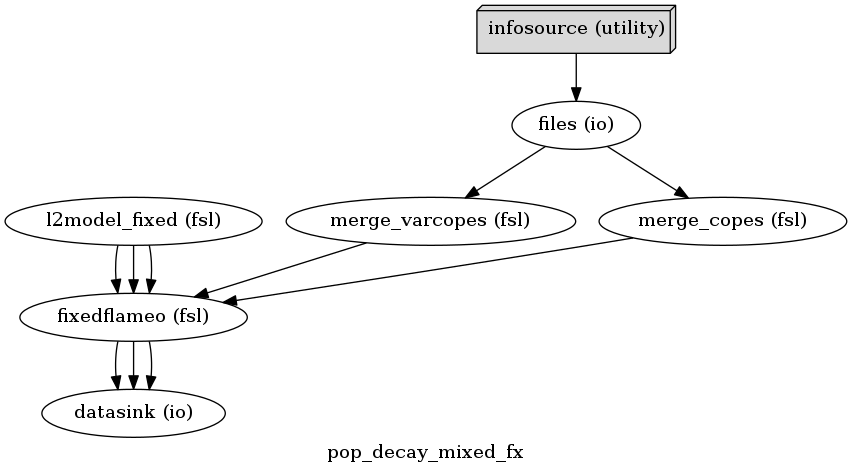

In [72]:
# mixed_fx.write_graph(
#     simple_form=True, 
#     graph2use="hierarchical", 
#     dotfilename="./graph_hierarchical.dot"
# )

# Image(filename="graph_hierarchical.png")

In [73]:
# mixed_fx.write_graph()
mixed_fx.run('MultiProc')

180604-23:56:28,11 workflow INFO:
	 Workflow pop_decay_mixed_fx settings: ['check', 'execution', 'logging', 'monitoring']
180604-23:56:28,89 workflow INFO:
	 Running in parallel.
180604-23:56:28,94 workflow INFO:
	 [MultiProc] Running 0 tasks, and 12 jobs ready. Free memory (GB): 10.47/10.47, Free processors: 4/4.
180604-23:56:28,137 workflow INFO:
	 [Node] Setting-up "pop_decay_mixed_fx.files" in "/data/ext/PhD/Studies/PrimingDecay/data/working_dir/pop_decay_mixed_fx/_con_num_10/files".180604-23:56:28,139 workflow INFO:
	 [Node] Setting-up "pop_decay_mixed_fx.files" in "/data/ext/PhD/Studies/PrimingDecay/data/working_dir/pop_decay_mixed_fx/_con_num_9/files".180604-23:56:28,141 workflow INFO:
	 [Node] Setting-up "pop_decay_mixed_fx.files" in "/data/ext/PhD/Studies/PrimingDecay/data/working_dir/pop_decay_mixed_fx/_con_num_8/files".

180604-23:56:28,147 workflow INFO:
	 [Node] Setting-up "pop_decay_mixed_fx.files" in "/data/ext/PhD/Studies/PrimingDecay/data/working_dir/pop_decay_mixed_fx